In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
sys.path.append(r"/Users/binxuwang/Github/Neuro-ActMax-GAN-comparison")
import pandas as pd
from os.path import join
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from core.utils.plot_utils import saveallforms
from neuro_data_analysis.neural_data_lib import load_neural_data, load_img_resp_pairs, load_latent_codes
from neuro_data_analysis.neural_data_lib import load_neural_data, extract_all_evol_trajectory_psth, extract_evol_activation_array, pad_psth_traj, get_expstr
from neuro_data_analysis.neural_data_utils import get_all_masks

In [4]:
source_data_root = r"/Users/binxuwang/Library/CloudStorage/OneDrive-HarvardUniversity/Manuscript_BigGAN/Submissions/Manuscript_BigGAN - NatNeuro/2025-10-Accepted-In-Principle-Docs/SourceData/"
source_data_dir = join(source_data_root, "Fig6_Source_data")
os.makedirs(source_data_dir, exist_ok=True)

### Figure 6C

Beto 11.0 Beto-07092020-003 prefchan 5.0 unit 2.0 class 0 axis

In [74]:
def regression_combined_plot(x_train, y_train, gauss_fit_results, ols_fit_results, gpr_fit_results, anova_results=None, title_str="", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.plot(x_train, y_train, 'o', label='data', alpha=0.5)
    tmp_df = pd.DataFrame({"x": x_train, "y": y_train})
    tmp_df = tmp_df.groupby("x").agg({"y": ["mean", "std"]}).reset_index()
    ax.errorbar(tmp_df["x"], tmp_df["y"]["mean"], yerr=tmp_df["y"]["std"], label='mean y', marker='D', color="C1", markersize=5, capsize=5, alpha=0.5, linestyle="")
    x_eval = np.linspace(x_train.min(), x_train.max(), 100)
    gauss_params = gauss_fit_results["params"]
    ols_params = ols_fit_results["params"]
    gpr_kernel = gpr_fit_results["gpr"].kernel_
    gpr_kernel_str = str(gpr_kernel).replace("length_scale", "len").replace("noise_level", "noise").replace("RBF", "RBF").replace("WhiteKernel", "White")
    if gauss_params is not None:
        ax.plot(x_eval, gaussian_with_baseline(x_eval, *gauss_params), label='Gaussian curvefit', color="k")
    ax.plot(x_eval, ols_params["slope"] * x_eval + ols_params["intercept"], label='OLS fit', color="magenta", linestyle="--")
    ax.plot(gpr_fit_results["x_eval"], gpr_fit_results["y_mean"], label='GPR mean', color="red")
    ax.fill_between(
        gpr_fit_results["x_eval"],
        gpr_fit_results["y_mean"] - gpr_fit_results["y_std"],
        gpr_fit_results["y_mean"] + gpr_fit_results["y_std"],
        alpha=0.2,
        label="GPR std",
        color="red"
    )
    ax.legend()
    title_caption = ""
    if title_str:
        title_caption += f"{title_str}\n"
    if gauss_params is not None:
        title_caption += f"Gauss fit: Ampl.: {gauss_params[0]:.2f} Mean: {gauss_params[1]:.2f} Std: {gauss_params[2]:.2f} Bsl: {gauss_params[3]:.2f} [R2: {gauss_fit_results['explained_variance']:.2f}]\n"
    if ols_params is not None:
        title_caption += f"OLS fit: Slope: {ols_fit_results['params']['slope']:.2f} Intercept: {ols_fit_results['params']['intercept']:.2f} [R2: {ols_fit_results['explained_variance']:.2f}]\n"
    if gpr_fit_results is not None:
        title_caption += f"GPR fit: {gpr_kernel_str} [R2: {gpr_fit_results['explained_variance']:.2f}]"
    if anova_results is not None:
        title_caption += f"\nANOVA: {anova_results['stats_str']}"
    ax.set_title(title_caption)
    fig.tight_layout()
    return fig

In [79]:
from sklearn.linear_model import LinearRegression

def linear_regression_fitting(x, y, visualize=True):
    # Initialize and fit the linear regression model
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    # Predict using the fitted model
    y_fit = model.predict(x.reshape(-1, 1))
    # Compute the explained variance (R^2 score)
    explained_variance = model.score(x.reshape(-1, 1), y)
    if visualize:
        plot_linear_regression_fit(x, y, model)
    
    return {
        "params": {
            "slope": model.coef_[0],
            "intercept": model.intercept_
        },
        "param_cov": None,  # Covariance matrix not available for simple linear regression
        "explained_variance": explained_variance
    }

def plot_linear_regression_fit(x, y, model):
    plt.plot(x, y, 'o', label='data', alpha=0.5)
    # Generate values for plotting the regression line
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = model.predict(x_fit.reshape(-1, 1))
    plt.plot(x_fit, y_fit, label='OLS fit', color="k")
    plt.legend()

In [80]:
from scipy.optimize import curve_fit
# Define Gaussian function with baseline
def gaussian_with_baseline(x, amplitude, mean, stddev, baseline):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2)) + baseline


def gaussian_curve_fitting(x, y, visualize=True, constrained=True):
    df_tmp = pd.DataFrame({"x": x, "y": y})
    df_tmp = df_tmp.groupby("x").agg({"y": ["mean", "std", "sem"]}).reset_index()
    x_uniq = df_tmp["x"]
    y_mean = df_tmp["y"]["mean"]
    y_std = df_tmp["y"]["std"]
    y_sem = df_tmp["y"]["sem"]
    # Initialize parameters
    x_range = np.max(x_uniq) - np.min(x_uniq)
    initial_amplitude = np.max(y_mean) - np.min(y_mean)
    initial_mean = x_uniq[np.argmax(y_mean)] # TODO: fix this, use the denoised / mean y data.
    initial_stddev = x_range / 4  # Arbitrary initial standard deviation
    initial_baseline = np.min(y_mean)

    initial_params = [initial_amplitude, initial_mean, initial_stddev, initial_baseline]
    if constrained:
        lower_bounds = [                 0.0,  np.min(x_uniq),         0.01,             0.0]
        upper_bounds = [1.25 * np.max(y_mean),  np.max(x_uniq),  x_range * 2,  np.max(y_mean)]
        bounds = (lower_bounds, upper_bounds)
    else:
        bounds = None
    # # Initialize parameters
    # initial_amplitude = np.max(y_mean) - np.min(y_mean)
    # initial_mean = x[np.argmax(y)] # TODO: fix this, use the denoised / mean y data.
    # initial_stddev = (np.max(x) - np.min(x)) / 4  # Arbitrary initial standard deviation
    # initial_baseline = np.min(y)

    # initial_params = [initial_amplitude, initial_mean, initial_stddev, initial_baseline]
    # if constrained:
    #     lower_bounds = [0.0,    np.min(x),  1e-6,   0.0]
    #     upper_bounds = [2 * np.max(y),  np.max(x),  (np.max(x) - np.min(x)) * 2,  1.5 * np.max(y)]
    #     bounds = (lower_bounds, upper_bounds)
    # else:
    #     bounds = None
    # Fit the curve with error handling
    try:
        params, param_cov = curve_fit(gaussian_with_baseline, x, y, p0=initial_params, bounds=bounds)
    except RuntimeError as e:
        print("Curve fitting failed:", e)
        params = None
        param_cov = None
    # compute the explained variance
    if params is not None:
        y_fit = gaussian_with_baseline(x, *params)
        explained_variance = 1 - np.var(y - y_fit) / np.var(y)
    else:
        explained_variance = None
    if visualize and params is not None:
        plot_gaussian_curve_fitting(x, y, params, )
    return {"params": params, 
            "param_cov": param_cov, 
            "explained_variance": explained_variance}


def plot_gaussian_curve_fitting(x, y, params,):
    plt.plot(x, y, 'o', label='data', alpha=0.5)
    # plot the mean y value per x value and error bars
    tmp_df = pd.DataFrame({"x": x, "y": y})
    tmp_df = tmp_df.groupby("x").agg({"y": ["mean", "std"]}).reset_index()
    plt.errorbar(tmp_df["x"], tmp_df["y"]["mean"], yerr=tmp_df["y"]["std"], fmt='D', label='mean y', marker='D', markersize=5, capsize=5, alpha=0.5)
    x_fit = np.linspace(x.min(), x.max(), 100)
    plt.plot(x_fit, gaussian_with_baseline(x_fit, *params), label='Gaussian curvefit', color="k")
    plt.legend()



In [81]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
# Suppose x_train is shape (N,1), y_train is shape (N,) or (N,1)
# Even if some x's are identical, the multiple rows with the same x
# will just appear as repeated entries in x_train.
def gaussian_process_regression(x_train, y_train, n_eval_points=100, visualize=True):
    """
    Perform Gaussian process regression on the input data.
    
    Args:
        x_train: Training x values, shape (N,1)
        y_train: Training y values, shape (N,) or (N,1)
        n_eval_points: Number of evaluation points to predict
    
    Returns:
        gpr: Gaussian process regressor
        x_eval: Evaluation x values
        y_mean: Predicted mean values
        y_std: Predicted standard deviation values
    """
    # Set length_scale based on the range of x_train
    length_scale = (x_train.max() - x_train.min()) / 10 # 0.08
    df_tmp = pd.DataFrame({"x": x_train, "y": y_train})
    df_tmp = df_tmp.groupby("x").agg({"y": ['var']}).reset_index()
    noise_var = df_tmp["y"]["var"].mean()
    y_var = y_train.var()
    if np.isnan(noise_var):
        # note this is possible when there is not enough data to estimate the noise variance.
        noise_var = y_var
    noise_level = noise_var * 0.1
    # Set noise_level based on the variance of y_train
    # noise_level = np.var(y_train) * 0.5 # note the noise level is variance.

    kernel = ConstantKernel(y_var, (y_var * 1e-2, y_var*1e2)) * \
        RBF(length_scale=length_scale, length_scale_bounds=(1e-2, 1e2)) \
         + WhiteKernel(noise_level=noise_level,
                       noise_level_bounds=(noise_var * 1e-2, noise_var * 1e1))
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=10) # 
    gpr.fit(x_train.reshape(-1, 1), y_train.reshape(-1))
    # compute the explained variance
    y_fit = gpr.predict(x_train.reshape(-1, 1))
    explained_variance = 1 - np.var(y_train - y_fit) / np.var(y_train)
    # Predict at new points
    x_eval = np.linspace(x_train.min(), x_train.max(), n_eval_points)
    y_mean, y_std = gpr.predict(x_eval.reshape(-1, 1), return_std=True)
    y_mean = y_mean.reshape(-1)
    if visualize:
        plot_gaussian_process_regression(x_train, y_train, x_eval, y_mean, y_std)
    return {"gpr": gpr, "explained_variance": explained_variance, "x_eval": x_eval, "y_mean": y_mean, "y_std": y_std, }


def plot_gaussian_process_regression(x_train, y_train, x_eval, y_mean, y_std,):
    plt.plot(x_train, y_train, 'o', label='data', alpha=0.5)
    plt.plot(x_eval, y_mean, label='GPR mean', color="k")
    plt.fill_between(x_eval, y_mean - y_std, y_mean + y_std, alpha=0.2, label="GPR std")
    plt.legend()


In [88]:

import statsmodels.api as sm
from statsmodels.formula.api import ols
def anova_test_df(df, x_col="lin_dist", y_col="pref_unit_resp"):
    anova_results = {}
    try:
        model = ols(f'{y_col} ~ C({x_col})', data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        F_value = anova_table.loc[f'C({x_col})', 'F']
        p_value = anova_table.loc[f'C({x_col})', 'PR(>F)']
        stats_str = f"F-val: {F_value:.2f} | p-val: {p_value:.1e}"
        anova_results["F_value"] = F_value
        anova_results["p_value"] = p_value
        anova_results["stats_str"] = stats_str
        anova_results["anova_table"] = anova_table
        anova_results["error"] = None
    except Exception as e:
        print(f"Error performing ANOVA : {e}")
        anova_results["F_value"] = np.nan
        anova_results["p_value"] = np.nan
        anova_results["stats_str"] = ""
        anova_results["anova_table"] = None
        anova_results["error"] = e
    return anova_results

Adding origin trials for class 1
Adding origin trials for class 2
Adding origin trials for class 3
Adding origin trials for class 6
Adding origin trials for class 9
Adding origin trials for class 13
Adding origin trials for class 17
Adding origin trials for class 21
Adding origin trials for class 25
Adding origin trials for class 30
Adding origin trials for class 40
Adding origin trials for class 60
Adding origin trials for noise 1
Adding origin trials for noise 2
Adding origin trials for noise 3
Adding origin trials for noise 4
Adding origin trials for noise 5
Adding origin trials for noise 6
Adding origin trials for noise 8
Adding origin trials for noise 10
Adding origin trials for noise 20
Adding origin trials for noise 30
Adding origin trials for noise 40


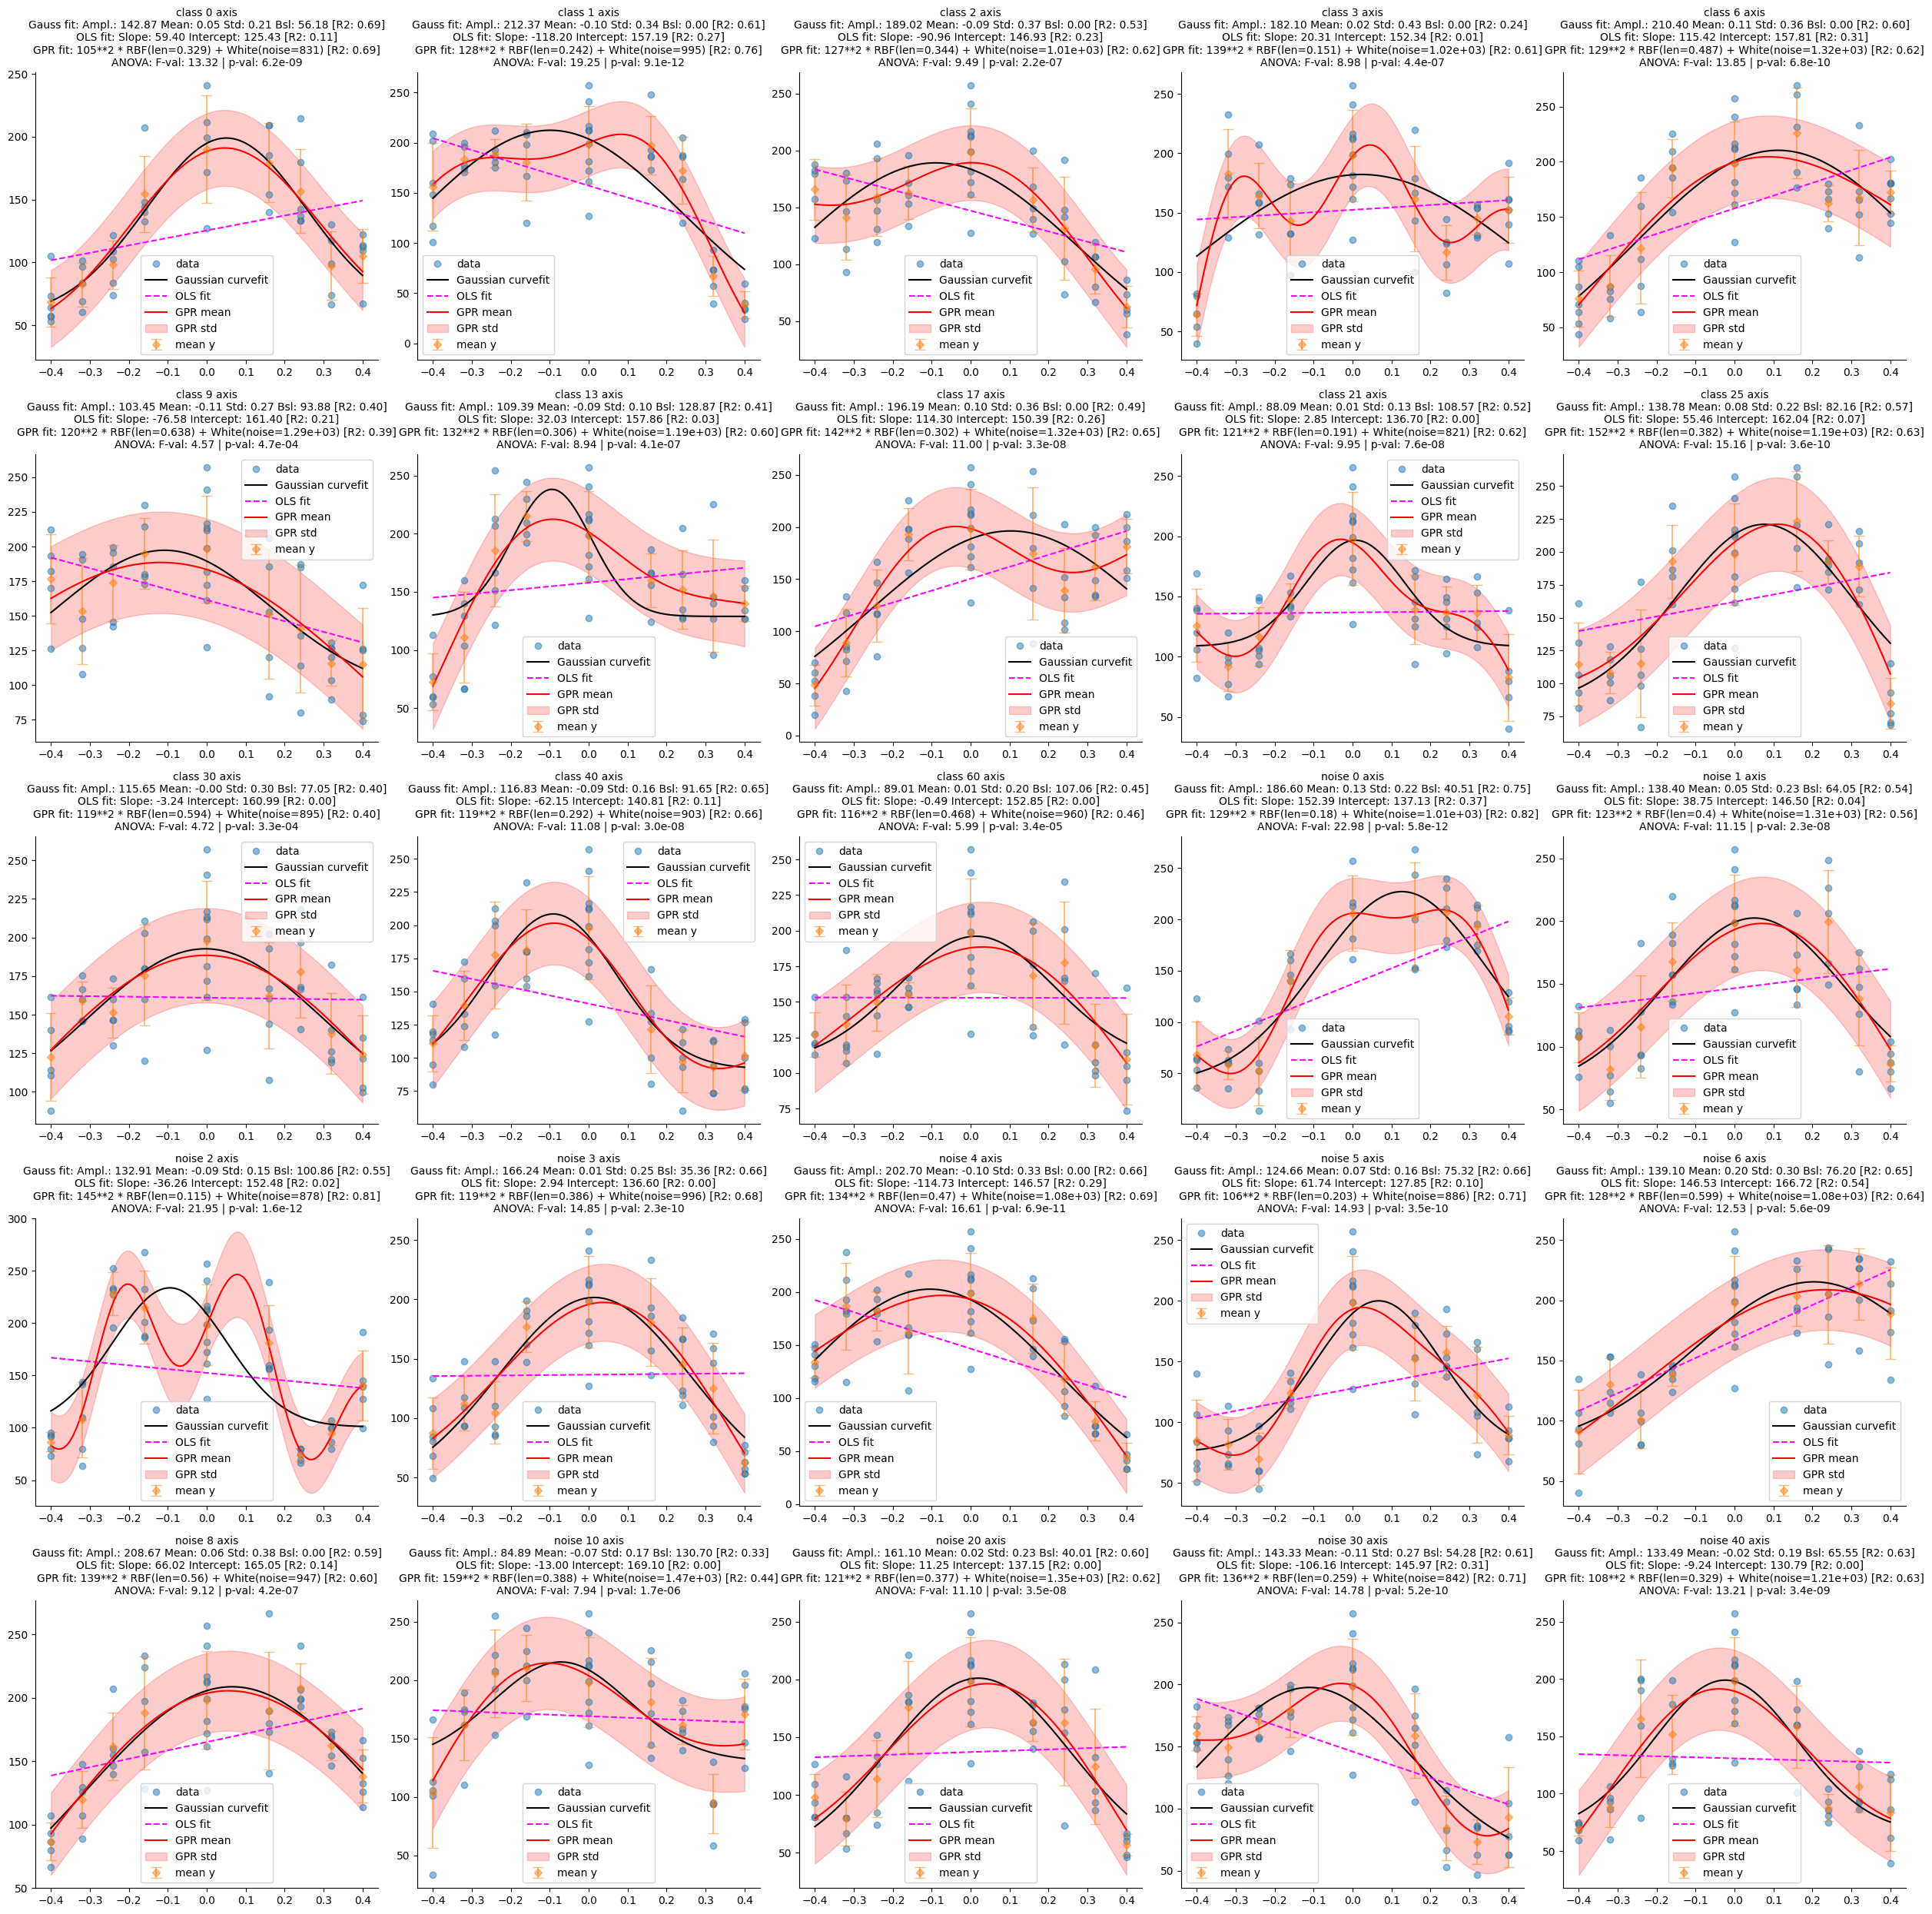

In [89]:
import math
# figroot = f"E:\OneDrive - Harvard University\BigGAN_Hessian"
figroot = f"/Users/binxuwang/Library/CloudStorage/OneDrive-HarvardUniversity/BigGAN_Hessian"
figdir = join(figroot, "Beto-07092020-003")
os.makedirs(figdir, exist_ok=True)
sgtr_resp_df = pd.read_csv(join(figdir, f"single_trial_pref_unit_resp.csv"))
sgtr_resp_at_origin = sgtr_resp_df.query(f"lin_dist == 0.0") # if some axis does not have origin stats, add it. 
axis_count = sgtr_resp_df[['space_name', 'eig_id']].drop_duplicates().shape[0]
ncols = 5
nrows = math.ceil(axis_count / ncols)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
ax_idx = 0
for ((space, eig_id), sgtr_resp_per_axis), ax in zip(sgtr_resp_df.groupby(['space_name', 'eig_id'], sort=True), axs.flatten()):
    if 0.0 not in sgtr_resp_per_axis["lin_dist"].unique():
        print(f"Adding origin trials for {space} {eig_id}")
        sgtr_resp_per_axis = pd.concat([sgtr_resp_per_axis, sgtr_resp_at_origin])
    gauss_fit_results = gaussian_curve_fitting(sgtr_resp_per_axis["lin_dist"].values, sgtr_resp_per_axis["pref_unit_resp"].values, visualize=False)
    ols_fit_results = linear_regression_fitting(sgtr_resp_per_axis["lin_dist"].values, sgtr_resp_per_axis["pref_unit_resp"].values, visualize=False)
    gpr_fit_results = gaussian_process_regression(sgtr_resp_per_axis["lin_dist"].values, sgtr_resp_per_axis["pref_unit_resp"].values, visualize=False)
    anova_results = anova_test_df(sgtr_resp_per_axis, x_col="lin_dist", y_col="pref_unit_resp")
    regression_combined_plot(sgtr_resp_per_axis["lin_dist"].values, sgtr_resp_per_axis["pref_unit_resp"].values, gauss_fit_results, ols_fit_results, gpr_fit_results, 
                               anova_results=anova_results, title_str=f"{space} {eig_id} axis", ax=ax)
    # change the title font size
    ax.set_title(ax.get_title(), fontsize=10)
    ax_idx += 1
# remove the extra axes 
for ax in axs.flatten()[ax_idx:]:
    ax.remove()
plt.tight_layout()
plt.show()

### Reproduction from loading

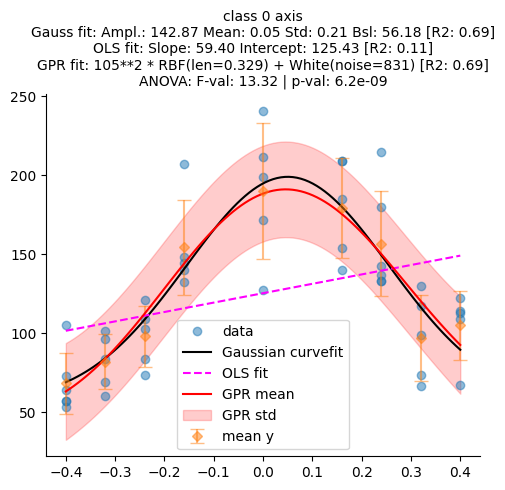

In [91]:
import math
# figroot = f"E:\OneDrive - Harvard University\BigGAN_Hessian"
figroot = f"/Users/binxuwang/Library/CloudStorage/OneDrive-HarvardUniversity/BigGAN_Hessian"
figdir = join(figroot, "Beto-07092020-003")
os.makedirs(figdir, exist_ok=True)
sgtr_resp_df = pd.read_csv(join(figdir, f"single_trial_pref_unit_resp.csv"))
sgtr_resp_at_origin = sgtr_resp_df.query(f"lin_dist == 0.0") # if some axis does not have origin stats, add it. 
axis_count = sgtr_resp_df[['space_name', 'eig_id']].drop_duplicates().shape[0]
ncols = 1
nrows = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
space, eig_id = "class", 0
sgtr_resp_per_axis = sgtr_resp_df.query(f"space_name == @space and eig_id == @eig_id")
# for ((space, eig_id), sgtr_resp_per_axis), ax in zip(sgtr_resp_df.groupby(['space_name', 'eig_id'], sort=True), axs.flatten()):
if 0.0 not in sgtr_resp_per_axis["lin_dist"].unique():
    print(f"Adding origin trials for {space} {eig_id}")
    sgtr_resp_per_axis = pd.concat([sgtr_resp_per_axis, sgtr_resp_at_origin])
gauss_fit_results = gaussian_curve_fitting(sgtr_resp_per_axis["lin_dist"].values, sgtr_resp_per_axis["pref_unit_resp"].values, visualize=False)
ols_fit_results = linear_regression_fitting(sgtr_resp_per_axis["lin_dist"].values, sgtr_resp_per_axis["pref_unit_resp"].values, visualize=False)
gpr_fit_results = gaussian_process_regression(sgtr_resp_per_axis["lin_dist"].values, sgtr_resp_per_axis["pref_unit_resp"].values, visualize=False)
anova_results = anova_test_df(sgtr_resp_per_axis, x_col="lin_dist", y_col="pref_unit_resp")
regression_combined_plot(sgtr_resp_per_axis["lin_dist"].values, sgtr_resp_per_axis["pref_unit_resp"].values, gauss_fit_results, ols_fit_results, gpr_fit_results, 
                            anova_results=anova_results, title_str=f"{space} {eig_id} axis", ax=ax)
# change the title font size
ax.set_title(ax.get_title(), fontsize=10)
plt.tight_layout()
plt.show()

In [92]:
sgtr_resp_df.to_csv(join(source_data_dir, "Figure6C_src_B07092020_sgtr_resp_df.csv"))
sgtr_resp_df.to_pickle(join(source_data_dir, "Figure6C_src_B07092020_sgtr_resp_df.pkl"))

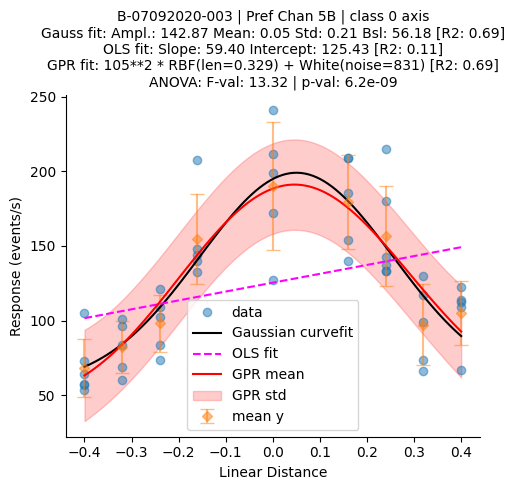

In [96]:
import math
title_str = "B-07092020-003 | Pref Chan 5B"
sgtr_resp_df = pd.read_csv(join(source_data_dir, "Figure6C_src_B07092020_sgtr_resp_df.csv"))
sgtr_resp_at_origin = sgtr_resp_df.query(f"lin_dist == 0.0") # if some axis does not have origin stats, add it. 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(ncols * 5, nrows * 5))
space, eig_id = "class", 0
sgtr_resp_per_axis = sgtr_resp_df.query(f"space_name == @space and eig_id == @eig_id")
if 0.0 not in sgtr_resp_per_axis["lin_dist"].unique():
    print(f"Adding origin trials for {space} {eig_id}")
    sgtr_resp_per_axis = pd.concat([sgtr_resp_per_axis, sgtr_resp_at_origin])
gauss_fit_results = gaussian_curve_fitting(sgtr_resp_per_axis["lin_dist"].values, sgtr_resp_per_axis["pref_unit_resp"].values, visualize=False)
ols_fit_results = linear_regression_fitting(sgtr_resp_per_axis["lin_dist"].values, sgtr_resp_per_axis["pref_unit_resp"].values, visualize=False)
gpr_fit_results = gaussian_process_regression(sgtr_resp_per_axis["lin_dist"].values, sgtr_resp_per_axis["pref_unit_resp"].values, visualize=False)
anova_results = anova_test_df(sgtr_resp_per_axis, x_col="lin_dist", y_col="pref_unit_resp")
regression_combined_plot(sgtr_resp_per_axis["lin_dist"].values, sgtr_resp_per_axis["pref_unit_resp"].values, gauss_fit_results, ols_fit_results, gpr_fit_results, 
                            anova_results=anova_results, title_str=f"{title_str} | {space} {eig_id} axis", ax=ax)
plt.xlabel("Linear Distance")
plt.ylabel("Response (events/s)")
ax.set_title(ax.get_title(), fontsize=10)
plt.tight_layout()
plt.show()

### Figure 6D

 Caos-12102024-003 | Pref Channel 68B 

In [112]:

def plot_heatmap(grouped, space, ax, CLIM, annot=True, fmt=".1f"):
    """Plot heatmap for a given space"""
    space_data = grouped[grouped['space_name'] == space]
    pivot_table = space_data.pivot(index='eig_id', columns='lin_dist', values='pref_unit_resp')
    pivot_table = pivot_table.astype(float)
    if pivot_table.empty:
        return
    plt.sca(ax)
    sns.heatmap(pivot_table, annot=annot, fmt=fmt, cmap=parula, 
                cbar_kws={'label': 'Preferred Unit Response'}, ax=ax, vmin=CLIM[0], vmax=CLIM[1])
    plt.title(f'Heatmap of Preferred Unit Response for Space: {space}')
    plt.xlabel('Linear Distance')
    plt.ylabel('Eigenvalue ID')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.axis('image')


In [ ]:
pkl_root = r"S:\Data-Ephys-PKL"

print("Processing: row", rowi, exprow.ephysFN, exprow.Animal, exprow.Expi)
figdir = join(figroot, exprow.ephysFN)
os.makedirs(figdir, exist_ok=True)

# Load data
data = pkl.load(open(join(pkl_root, f"{exprow.ephysFN}.pkl"), "rb"))
rasters = data["rasters"]
meta = data["meta"]
Trials = data["Trials"]
stimuli_dir = exprow.stimuli
imageName = np.squeeze(Trials.imageName)
# Process unit information
meta = maybe_add_unit_id_to_meta(meta, rasters,) # for older experiments, unit_id is not in the meta file
unit_info = organize_unit_info(meta, exprow)
prefchan_id = unit_info["prefchan_id"]
prefchan_str = unit_info["prefchan_str"]
expstr = f"{exprow.ephysFN} | Pref Channel {prefchan_str}"

# Process image names
# unique_imgnames = np.unique(imageName)
# stim_info_df = parse_stim_info(unique_imgnames)
# indices_per_name = {name: np.where(imageName == name)[0] for name in unique_imgnames}
# stim_info_df["trial_ids"] = stim_info_df.apply(lambda row: indices_per_name[row["img_name"]], axis=1)
# uniq_img_fps = find_full_image_paths(stimuli_dir, unique_imgnames)

# # make the image dataset
# stimuli_dataset = ImagePathDataset(list(uniq_img_fps.values()), scores=None, img_dim=(256, 256))

# Calculate responses
resp_info = calculate_neural_responses(rasters, prefchan_id)
prefchan_resp_sgtr = resp_info["prefchan_resp_sgtr"]
prefchan_bsl_mean = resp_info["prefchan_bsl_mean"]
prefchan_bsl_sem = resp_info["prefchan_bsl_sem"]

# Create response dataframe
sgtr_resp_df = pd.DataFrame({"img_name": imageName, "pref_unit_resp": prefchan_resp_sgtr[:, 0]})
# annotate the response dataframe with the stimulus information by merging on the image name
sgtr_resp_df = sgtr_resp_df.merge(stim_info_df.drop(columns=['trial_ids']), on="img_name")
# compute the average response per space and eigenvector
pref_avgresp_df = sgtr_resp_df.groupby(['space_name', 'eig_id', 'lin_dist']).agg({'pref_unit_resp': 'mean'}).reset_index()
pref_avg_resp_class = pref_avgresp_df.query(f"space_name == 'class'")
pref_avg_resp_noise = pref_avgresp_df.query(f"space_name == 'noise'")
pref_avg_resp_noise_mat = pref_avg_resp_noise.pivot(index='eig_id', columns='lin_dist', values='pref_unit_resp')
pref_avg_resp_class_mat = pref_avg_resp_class.pivot(index='eig_id', columns='lin_dist', values='pref_unit_resp')


In [ ]:
# Group and plot heatmaps
CLIM = np.quantile(pref_avgresp_df['pref_unit_resp'], [0.02, 0.98])
figh, axs = plt.subplots(1, 2, figsize=(13, 6))
for ax, space in zip(axs, ['class', 'noise']):
    plot_heatmap(pref_avgresp_df, space, ax, CLIM)
plt.suptitle(f'Preferred Unit Response for Different Spaces and Eigenvectors \n {exprow.ephysFN} | Pref Channel {prefchan_str} ')
plt.tight_layout()
saveallforms(figdir, f"preferred_unit_response_heatmap_py")
plt.show()

#### Export from summary statistics

In [39]:
tuning_stats_synopsis_df_fillmissing = pd.read_pickle(join(syndir, f"ABCD_tuning_stats_synopsis_fill_missing.pkl"))

In [45]:
exp_tuningcurve_df = tuning_stats_synopsis_df_fillmissing.query("ephysFN == 'Caos-12102024-003' ")

In [46]:
exp_tuningcurve_df

,space_name,eig_id,F_value,p_value,stats_str,lin_dist_set,lin_dist_num,avg_resp_per_lin_dist,repeat_per_lin_dist,max_resp_lin_dist,max_resp_val,Animal,Expi,ephysFN,stimuli,prefchan,prefunit,prefchan_str,prefchan_bsl_mean,prefchan_bsl_sem
85,class,0.0,4.413616,2.727797e-04,F-val: 4.41 | p-val: 2.7e-04,"[-0.4, -0.32, -0.24, -0.16, 0.0, 0.16, 0.24, 0...",9,"[67.49193572998047, 81.60189056396484, 119.357...","[8, 8, 8, 8, 8, 8, 9, 8, 8]",0.40,125.998627,Caos,6.0,Caos-12102024-003,N:\Stimuli\Evolutions\2024\2024-12-10-Ev-Caos-...,68.0,2.0,68B,27.715117,0.854681
86,class,1.0,8.368423,9.153928e-08,F-val: 8.37 | p-val: 9.2e-08,"[-0.4, -0.32, -0.24, -0.16, 0.0, 0.16, 0.24, 0...",9,"[41.55302047729492, 70.0455551147461, 71.79067...","[9, 8, 8, 8, 9, 8, 8, 8, 9]",0.00,111.588776,Caos,6.0,Caos-12102024-003,N:\Stimuli\Evolutions\2024\2024-12-10-Ev-Caos-...,68.0,2.0,68B,27.715117,0.854681
87,class,2.0,27.120554,4.541187e-18,F-val: 27.12 | p-val: 4.5e-18,"[-0.4, -0.32, -0.24, -0.16, 0.0, 0.16, 0.24, 0...",9,"[35.32529830932617, 46.88468933105469, 64.5457...","[9, 8, 9, 8, 8, 8, 8, 9, 8]",0.16,118.510643,Caos,6.0,Caos-12102024-003,N:\Stimuli\Evolutions\2024\2024-12-10-Ev-Caos-...,68.0,2.0,68B,27.715117,0.854681
88,class,3.0,10.650531,2.012532e-09,F-val: 10.65 | p-val: 2.0e-09,"[-0.4, -0.32, -0.24, -0.16, 0.0, 0.16, 0.24, 0...",9,"[63.91450500488281, 77.15209197998047, 76.8209...","[8, 9, 8, 9, 8, 8, 8, 8, 8]",-0.16,110.862610,Caos,6.0,Caos-12102024-003,N:\Stimuli\Evolutions\2024\2024-12-10-Ev-Caos-...,68.0,2.0,68B,27.715117,0.854681
89,class,6.0,18.991862,2.978958e-14,F-val: 18.99 | p-val: 3.0e-14,"[-0.4, -0.32, -0.24, -0.16, 0.0, 0.16, 0.24, 0...",9,"[23.755529403686523, 51.140777587890625, 81.36...","[9, 8, 8, 8, 8, 8, 8, 8, 8]",0.16,105.020851,Caos,6.0,Caos-12102024-003,N:\Stimuli\Evolutions\2024\2024-12-10-Ev-Caos-...,68.0,2.0,68B,27.715117,0.854681
90,class,9.0,8.044778,1.656773e-07,F-val: 8.04 | p-val: 1.7e-07,"[-0.4, -0.32, -0.24, -0.16, 0.0, 0.16, 0.24, 0...",9,"[91.89859008789062, 102.47750854492188, 97.823...","[8, 8, 9, 9, 9, 8, 8, 8, 8]",-0.16,122.642227,Caos,6.0,Caos-12102024-003,N:\Stimuli\Evolutions\2024\2024-12-10-Ev-Caos-...,68.0,2.0,68B,27.715117,0.854681
91,class,13.0,8.471765,8.223027e-08,F-val: 8.47 | p-val: 8.2e-08,"[-0.4, -0.32, -0.24, -0.16, 0.0, 0.16, 0.24, 0...",9,"[48.361427307128906, 69.241455078125, 90.54240...","[8, 8, 8, 8, 9, 8, 8, 9, 8]",0.40,121.050880,Caos,6.0,Caos-12102024-003,N:\Stimuli\Evolutions\2024\2024-12-10-Ev-Caos-...,68.0,2.0,68B,27.715117,0.854681
92,class,21.0,11.034561,1.224452e-09,F-val: 11.03 | p-val: 1.2e-09,"[-0.4, -0.32, -0.24, -0.16, 0.0, 0.16, 0.24, 0...",9,"[48.95016860961914, 51.88395309448242, 81.3557...","[8, 8, 8, 9, 8, 8, 8, 8, 8]",-0.16,115.781441,Caos,6.0,Caos-12102024-003,N:\Stimuli\Evolutions\2024\2024-12-10-Ev-Caos-...,68.0,2.0,68B,27.715117,0.854681
93,class,30.0,3.610760,1.525773e-03,F-val: 3.61 | p-val: 1.5e-03,"[-0.4, -0.32, -0.24, -0.16, 0.0, 0.16, 0.24, 0...",9,"[65.09028625488281, 83.57923126220703, 91.9615...","[9, 9, 9, 8, 8, 8, 8, 9, 8]",-0.16,107.940102,Caos,6.0,Caos-12102024-003,N:\Stimuli\Evolutions\2024\2024-12-10-Ev-Caos-...,68.0,2.0,68B,27.715117,0.854681
94,class,60.0,0.749523,6.477908e-01,F-val: 0.75 | p-val: 6.5e-01,"[-0.4, -0.32, -0.24, -0.16, 0.0, 0.16, 0.24, 0...",9,"[95.12638092041016, 98.68932342529297, 112.926...","[8, 8, 8, 8, 9, 8, 8, 8, 8]",-0.24,112.926781,Caos,6.0,Caos-12102024-003,N:\Stimuli\Evolutions\2024\2024-12-10-Ev-Caos-...,68.0,2.0,68B,27.715117,0.854681


In [56]:
resp_collection = []
for _, row in exp_tuningcurve_df.iterrows():
    for lin_dist, resp, rep in zip(row["lin_dist_set"], row["avg_resp_per_lin_dist"], row["repeat_per_lin_dist"]):
        resp_collection.append({
            "ephysFN": row["ephysFN"],
            "prefchan": int(row["prefchan"]),
            "prefunit": int(row["prefunit"]),
            "prefchan_str": row["prefchan_str"],
            "bsl_mean": row["prefchan_bsl_mean"],
            "bsl_sem": row["prefchan_bsl_sem"],
            "eig_id": int(row["eig_id"]),
            "space_name": row["space_name"],
            "lin_dist": lin_dist,
            "pref_unit_resp": resp,
            "n_repeats": int(rep),
        })
avgresp_df = pd.DataFrame(resp_collection)

In [71]:
avgresp_df.to_pickle(join(source_data_dir, "Figure6D_src_prefchan_avgresp_df.pkl"))
avgresp_df.to_csv(join(source_data_dir, "Figure6D_src_prefchan_avgresp_df.csv"))

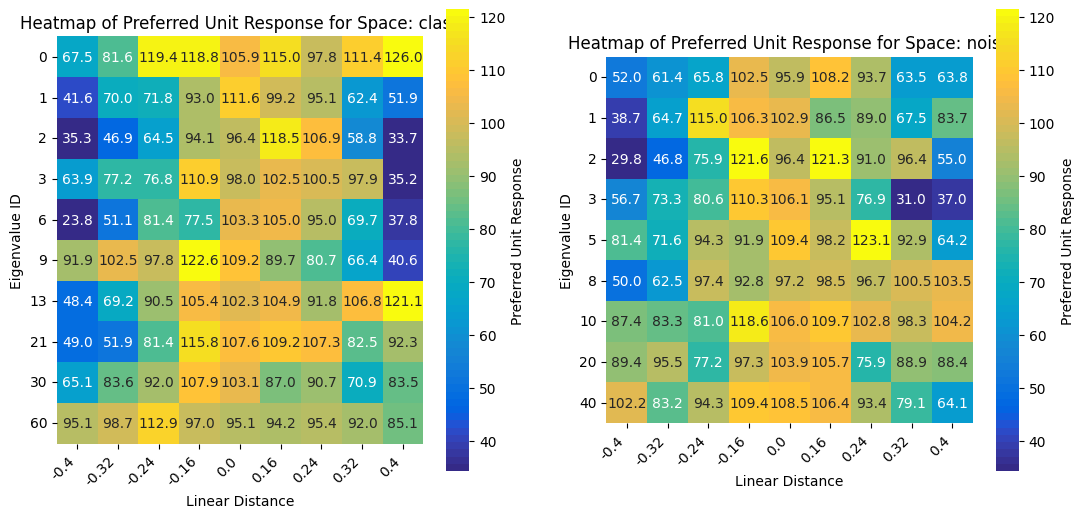

In [ ]:
from core.utils.colormap_matlab import parula, viridis

CLIM = np.quantile(avgresp_df['pref_unit_resp'], [0.02, 0.98])
figh, axs = plt.subplots(1, 2, figsize=(13, 6))
for ax, space in zip(axs, ['class', 'noise']):
    plot_heatmap(avgresp_df, space, ax, CLIM)

### Reproduce plot from the csv

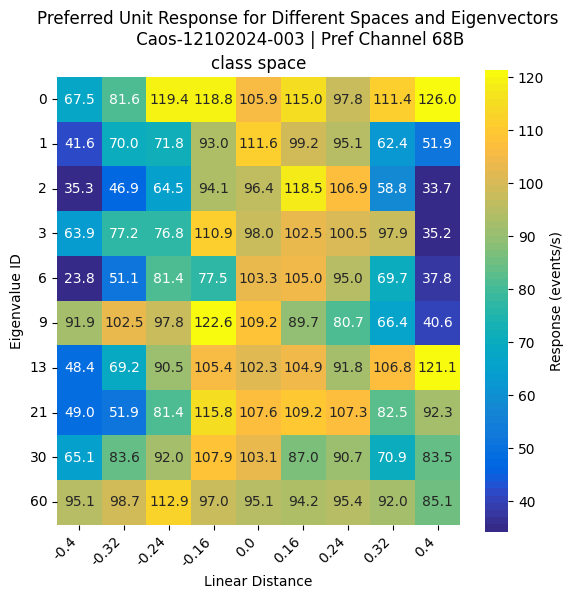

In [ ]:
# avgresp_df = pd.read_pickle(join(source_data_dir, "Figure6D_src_prefchan_avgresp_df.pkl"))
avgresp_df = pd.read_csv(join(source_data_dir, "Figure6D_src_prefchan_avgresp_df.csv"))

ephysFN = avgresp_df.iloc[0]["ephysFN"]
prefchan_str = avgresp_df.iloc[0]["prefchan_str"]
CLIM = np.quantile(avgresp_df['pref_unit_resp'], [0.02, 0.98])
figh, ax = plt.subplots(1, 1, figsize=(6.5, 6))
space = "class" # can also be "noise"
fig = plot_heatmap(avgresp_df, space, ax, CLIM)
plt.title(f'{space} space')
cbar = ax.figure.axes[-1]  # Get the last axis, which is the colorbar
cbar.set_ylabel("Response (events/s)")
plt.suptitle(f'Preferred Unit Response for Different Spaces and Eigenvectors \n {ephysFN} | Pref Channel {prefchan_str} ')
plt.show()

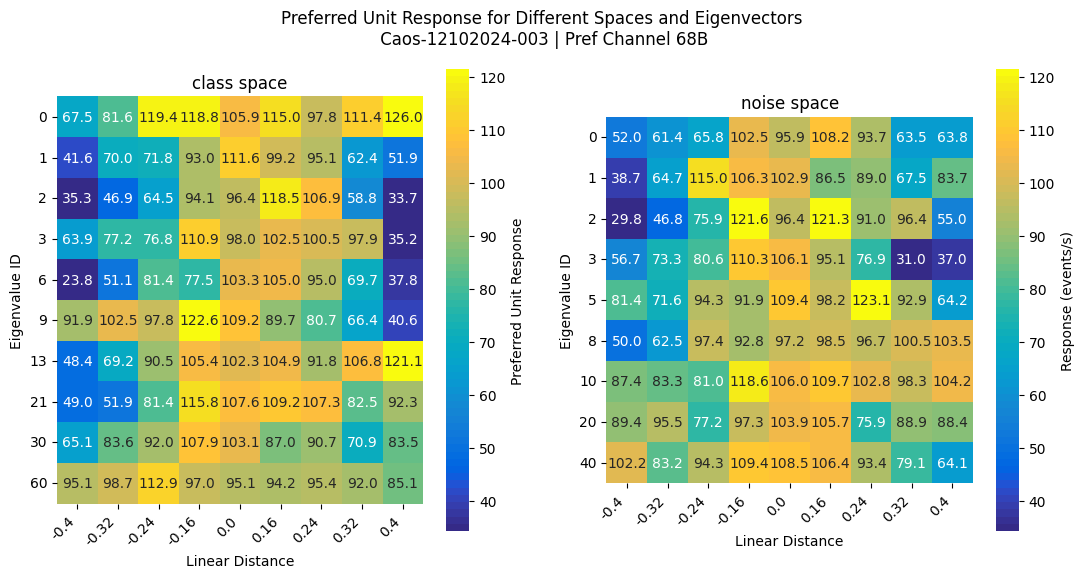

In [73]:

ephysFN = avgresp_df.iloc[0]["ephysFN"]
prefchan_str = avgresp_df.iloc[0]["prefchan_str"]
CLIM = np.quantile(avgresp_df['pref_unit_resp'], [0.02, 0.98])
figh, axs = plt.subplots(1, 2, figsize=(13, 6))
for ax, space in zip(axs, ['class', 'noise']):
    fig = plot_heatmap(avgresp_df, space, ax, CLIM)
    plt.title(f'{space} space')
cbar = ax.figure.axes[-1]  # Get the last axis, which is the colorbar
cbar.set_ylabel("Response (events/s)")
plt.suptitle(f'Preferred Unit Response for Different Spaces and Eigenvectors \n {ephysFN} | Pref Channel {prefchan_str} ')
plt.show()

### Figure 6D alternative

In [97]:
tuning_fitting_stats_table['is_BigGAN_evol_success'] = tuning_fitting_stats_table['Exp_id'].isin(BigGAN_success_explist)

In [103]:
tuning_fitting_stats_table.query("~is_BigGAN_evol_success").ephysFN.unique()

array(['Diablito-12122024-004', 'Alfa-04082020-003', 'Alfa-06082020-004',
       'Alfa-10082020-004', 'Alfa-14082020-003', 'Alfa-27082020-003',
       'Alfa-02092020-004', 'Alfa-02092020-006', 'Alfa-08092020-004',
       'Alfa-11092020-003', 'Alfa-11092020-006', 'Alfa-16092020-003',
       'Alfa-16092020-005', 'Alfa-27102020-007', 'Alfa-27102020-008',
       'Alfa-27102020-009', 'Alfa-26022021-005', 'Beto-05082020-003',
       'Beto-13082020-004', 'Beto-17082020-004', 'Beto-20082020-004',
       'Beto-10092020-003', 'Beto-14092020-004'], dtype=object)

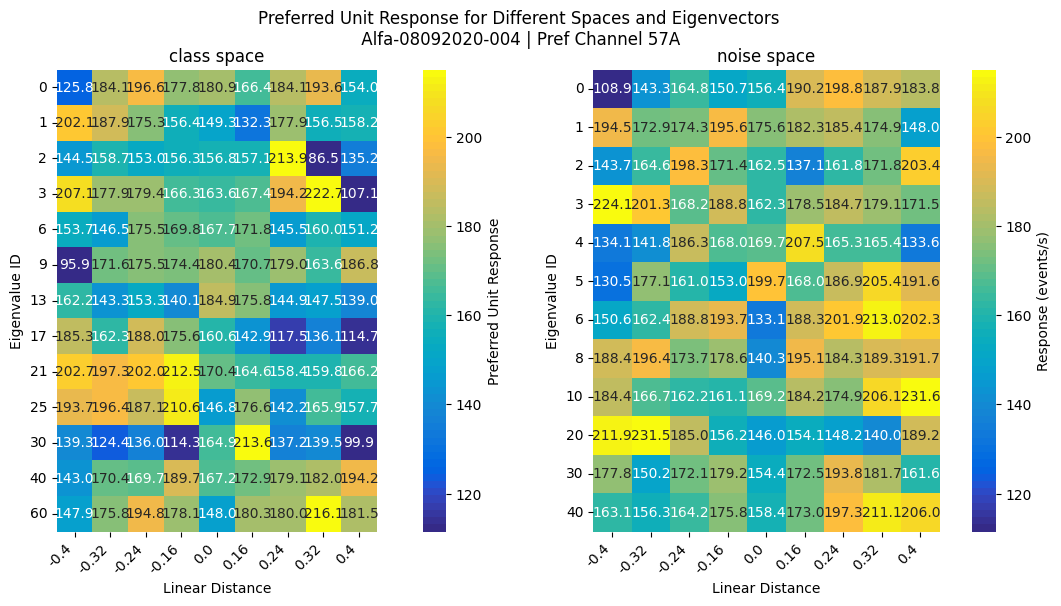

In [121]:

from core.utils.colormap_matlab import parula, viridis
exp_tuningcurve_df = tuning_stats_synopsis_df_fillmissing.query("ephysFN == 'Alfa-08092020-004' ")
resp_collection = []
for _, row in exp_tuningcurve_df.iterrows():
    for lin_dist, resp, rep in zip(row["lin_dist_set"], row["avg_resp_per_lin_dist"], row["repeat_per_lin_dist"]):
        resp_collection.append({
            "ephysFN": row["ephysFN"],
            "prefchan": int(row["prefchan"]),
            "prefunit": int(row["prefunit"]),
            "prefchan_str": row["prefchan_str"],
            "bsl_mean": row["prefchan_bsl_mean"],
            "bsl_sem": row["prefchan_bsl_sem"],
            "eig_id": int(row["eig_id"]),
            "space_name": row["space_name"],
            "lin_dist": lin_dist,
            "pref_unit_resp": resp,
            "n_repeats": int(rep),
        })
avgresp_df = pd.DataFrame(resp_collection)
from core.utils.colormap_matlab import parula, viridis
ephysFN = avgresp_df.ephysFN.iloc[0]
prefchan_str = avgresp_df.prefchan_str.iloc[0]
CLIM = np.quantile(avgresp_df['pref_unit_resp'], [0.02, 0.98])
figh, axs = plt.subplots(1, 2, figsize=(13, 6))
for ax, space in zip(axs, ['class', 'noise']):
    plot_heatmap(avgresp_df, space, ax, CLIM, annot=True)
    plt.title(f'{space} space')
cbar = ax.figure.axes[-1]  # Get the last axis, which is the colorbar
cbar.set_ylabel("Response (events/s)")
plt.suptitle(f'Preferred Unit Response for Different Spaces and Eigenvectors \n {ephysFN} | Pref Channel {prefchan_str} ')
plt.show()

In [122]:
avgresp_df.to_pickle(join(source_data_dir, "Figure6D_src_prefchan_avgresp_df_failevol.pkl"))
avgresp_df.to_csv(join(source_data_dir, "Figure6D_src_prefchan_avgresp_df_failevol.csv"))

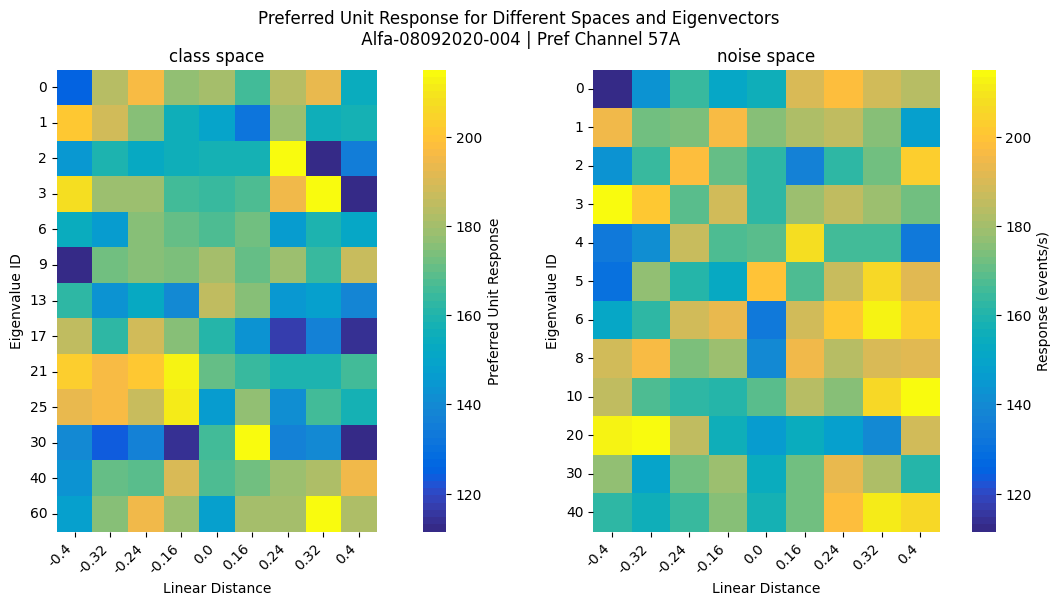

In [116]:
exp_tuningcurve_df = tuning_stats_synopsis_df_fillmissing.query("ephysFN == 'Alfa-08092020-004' ")
resp_collection = []
for _, row in exp_tuningcurve_df.iterrows():
    for lin_dist, resp, rep in zip(row["lin_dist_set"], row["avg_resp_per_lin_dist"], row["repeat_per_lin_dist"]):
        resp_collection.append({
            "ephysFN": row["ephysFN"],
            "prefchan": int(row["prefchan"]),
            "prefunit": int(row["prefunit"]),
            "prefchan_str": row["prefchan_str"],
            "bsl_mean": row["prefchan_bsl_mean"],
            "bsl_sem": row["prefchan_bsl_sem"],
            "eig_id": int(row["eig_id"]),
            "space_name": row["space_name"],
            "lin_dist": lin_dist,
            "pref_unit_resp": resp,
            "n_repeats": int(rep),
        })
avgresp_df = pd.DataFrame(resp_collection)
from core.utils.colormap_matlab import parula, viridis
ephysFN = avgresp_df.ephysFN.iloc[0]
prefchan_str = avgresp_df.prefchan_str.iloc[0]
CLIM = np.quantile(avgresp_df['pref_unit_resp'], [0.02, 0.98])
figh, axs = plt.subplots(1, 2, figsize=(13, 6))
for ax, space in zip(axs, ['class', 'noise']):
    plot_heatmap(avgresp_df, space, ax, CLIM, annot=False)
    plt.title(f'{space} space')
cbar = ax.figure.axes[-1]  # Get the last axis, which is the colorbar
cbar.set_ylabel("Response (events/s)")
plt.suptitle(f'Preferred Unit Response for Different Spaces and Eigenvectors \n {ephysFN} | Pref Channel {prefchan_str} ')
saveallforms(source_data_dir, f"{ephysFN}_U{prefchan_str}_unsucc_tuning_maps_noannot")
plt.show()

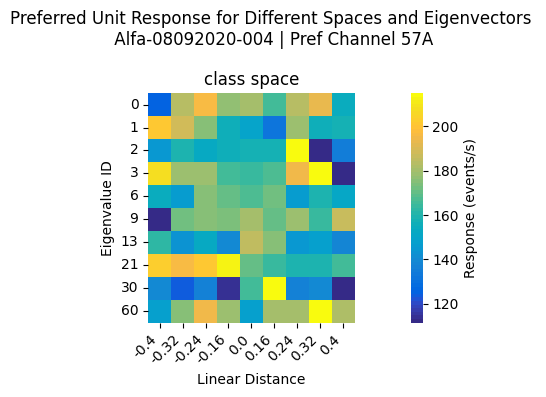

In [119]:
exp_tuningcurve_df = tuning_stats_synopsis_df_fillmissing.query("ephysFN == 'Alfa-08092020-004' ")
resp_collection = []
for _, row in exp_tuningcurve_df.iterrows():
    for lin_dist, resp, rep in zip(row["lin_dist_set"], row["avg_resp_per_lin_dist"], row["repeat_per_lin_dist"]):
        resp_collection.append({
            "ephysFN": row["ephysFN"],
            "prefchan": int(row["prefchan"]),
            "prefunit": int(row["prefunit"]),
            "prefchan_str": row["prefchan_str"],
            "bsl_mean": row["prefchan_bsl_mean"],
            "bsl_sem": row["prefchan_bsl_sem"],
            "eig_id": int(row["eig_id"]),
            "space_name": row["space_name"],
            "lin_dist": lin_dist,
            "pref_unit_resp": resp,
            "n_repeats": int(rep),
        })
avgresp_df = pd.DataFrame(resp_collection)
from core.utils.colormap_matlab import parula, viridis
ephysFN = avgresp_df.ephysFN.iloc[0]
prefchan_str = avgresp_df.prefchan_str.iloc[0]
CLIM = np.quantile(avgresp_df['pref_unit_resp'], [0.02, 0.98])
figh, axs = plt.subplots(1, 1, figsize=(4.5, 4))
ax = axs
space = "class"
# for ax, space in zip(axs, ['class', 'noise']):
plot_heatmap(avgresp_df.query("eig_id in [0,1,2,3,6,9,13,21,30,60]"), space, ax, CLIM, annot=False)
plt.title(f'{space} space')
cbar = ax.figure.axes[-1]  # Get the last axis, which is the colorbar
cbar.set_ylabel("Response (events/s)")
plt.suptitle(f'Preferred Unit Response for Different Spaces and Eigenvectors \n {ephysFN} | Pref Channel {prefchan_str} ')
plt.tight_layout()
saveallforms(source_data_dir, f"{ephysFN}_U{prefchan_str}_unsucc_tuning_maps_noannot_prune")
plt.show()

### Figure 6E

In [7]:
figroot = f"/Users/binxuwang/Library/CloudStorage/OneDrive-HarvardUniversity/BigGAN_Hessian"
syndir = join(figroot, "synopsis")
os.makedirs(syndir, exist_ok=True)

In [10]:
tuning_stats_synopsis_df_fillmissing = pd.read_pickle(join(syndir, f"ABCD_tuning_stats_synopsis_fill_missing.pkl"))
evol_stats_synopsis_df = pd.read_pickle(join(syndir, f"ABCD_evol_stats_synopsis.pkl"))
tuning_fitting_stats_table = pd.read_pickle(join(syndir, "tuning_shape_fitting_stats_synopsis.pkl"))

tuning_fitting_stats_table['Exp_id'] = tuning_fitting_stats_table.apply(lambda row: f"{row['Animal']}_{int(row['Expi'])}", axis=1)
evol_stats_synopsis_df['Exp_id'] = evol_stats_synopsis_df.apply(lambda row: f"{row['Animal']}_{int(row['Expi'])}", axis=1)

In [18]:
import numpy as np

def is_monotonic_np(y_values: np.ndarray, EPS: float = 0.01) -> bool:
    """
    Determines if the given NumPy array y_values is monotonic 
    (entirely non-increasing or non-decreasing).

    Args:
        y_values (np.ndarray): Sequence of numerical y-values.
        EPS (float): Tolerance for considering two values as equal (default is 0.01).

    Returns:
        bool: True if the sequence is monotonic, False otherwise.
    """
    if y_values.size <= 1:
        return True  # Empty or single-element sequences are monotonic

    diffs = np.diff(y_values)

    # Check for non-decreasing: all diffs >= -EPS
    non_decreasing = np.all(diffs >= -EPS)

    # Check for non-increasing: all diffs <= EPS
    non_increasing = np.all(diffs <= EPS)

    return non_decreasing or non_increasing


def is_unimodal_np(y_values: np.ndarray, EPS: float = 0.01) -> bool:
    """
    Determines if the given NumPy array y_values is unimodal 
    (has a single peak).

    Args:
        y_values (np.ndarray): Sequence of numerical y-values.
        EPS (float): Tolerance for considering two values as equal (default is 0.01).

    Returns:
        bool: True if the sequence is unimodal, False otherwise.
    """
    if y_values.size == 0:
        return False  # Empty sequence is not unimodal
    if y_values.size == 1:
        return True  # Single element is trivially unimodal

    # Find the index of the first occurrence of the maximum value
    peak_index = np.argmax(y_values)

    # Split the array into two parts: before and after the peak
    before_peak = y_values[:peak_index + 1]
    after_peak = y_values[peak_index:]

    # Compute differences for both parts
    diffs_before = np.diff(before_peak)
    diffs_after = np.diff(after_peak)

    # Check if the sequence before the peak is non-decreasing
    is_non_decreasing = np.all(diffs_before >= -EPS)

    # Check if the sequence after the peak is non-increasing
    is_non_increasing = np.all(diffs_after <= EPS)

    return is_non_decreasing and is_non_increasing



def is_bellshaped_np(y_values: np.ndarray, EPS: float = 0.01) -> bool:
    """
    Determines if the given NumPy array y_values is bellshaped 
    (has a single peak and is unimodal).

    Args:
        y_values (np.ndarray): Sequence of numerical y-values.
        EPS (float): Tolerance for considering two values as equal (default is 0.01).

    Returns:
        bool: True if the sequence is unimodal, False otherwise.
    """
    if y_values.size == 0:
        return False  # Empty sequence is not unimodal
    if y_values.size == 1:
        return True  # Single element is trivially unimodal

    # Find the index of the first occurrence of the maximum value
    peak_index = np.argmax(y_values)
    if peak_index == 0 or peak_index == y_values.size - 1:
        return False # the peak is at the boundary, not bellshaped
    # Split the array into two parts: before and after the peak
    before_peak = y_values[:peak_index + 1]
    after_peak = y_values[peak_index:]

    # Compute differences for both parts
    diffs_before = np.diff(before_peak)
    diffs_after = np.diff(after_peak)

    # Check if the sequence before the peak is non-decreasing
    is_non_decreasing = np.all(diffs_before >= -EPS)

    # Check if the sequence after the peak is non-increasing
    is_non_increasing = np.all(diffs_after <= EPS)

    return is_non_decreasing and is_non_increasing

In [19]:
tuning_fitting_stats_table["gpr_y_is_unimodal"] = tuning_fitting_stats_table.apply(lambda row: is_unimodal_np(row["gpr_y_mean"]), axis=1)
tuning_fitting_stats_table["gpr_y_is_monotonic"] = tuning_fitting_stats_table.apply(lambda row: is_monotonic_np(row["gpr_y_mean"]), axis=1)
tuning_fitting_stats_table["gpr_y_is_bellshaped"] = tuning_fitting_stats_table.apply(lambda row: is_bellshaped_np(row["gpr_y_mean"]), axis=1)

In [ ]:
BigGAN_success_explist = evol_stats_synopsis_df.query("lastinit_thr1_pval < 0.01")['Exp_id']
# find the corresponding masks in tuning stats
BigGAN_success_mask_tuning_stats = tuning_fitting_stats_table.query("Exp_id in @BigGAN_success_explist")
BigGAN_fail_mask_tuning_stats = tuning_fitting_stats_table.query("Exp_id not in @BigGAN_success_explist")
tuning_fitting_stats_table['is_BigGAN_evol_success'] = tuning_fitting_stats_table['Exp_id'].isin(BigGAN_success_explist)

In [21]:
tuning_fitting_stats_table['is_common_axis'] = tuning_fitting_stats_table.apply(lambda row: row['x_values'].max() == 0.4 and row['x_values'].min() == -0.4, axis=1)

In [32]:
tuning_fitting_stats_table_sel = tuning_fitting_stats_table.loc[:, ['Animal', 'Exp_id', 'space', 'eig_id', 
                    'anova_F_value', 'anova_p_value', 'anova_R2',
                    'ols_R2','ols_slope','ols_intercept',
                    'gauss_R2', 'gauss_fit_amplitude', 'gauss_fit_center', 'gauss_fit_sigma', 'gauss_fit_offset',
                    'gpr_R2',
                    'is_BigGAN_evol_success', 'is_common_axis', 
                    'gpr_y_is_unimodal', 'gpr_y_is_monotonic', 'gpr_y_is_bellshaped']]

In [35]:
tuning_fitting_stats_table.to_pickle(join(source_data_dir, "Figure6E_src_tuning_shape_fitting_stats_synopsis_sel.pkl"))
tuning_fitting_stats_table_sel.to_csv(join(source_data_dir, "Figure6E_src_tuning_shape_fitting_stats_synopsis_selcolumn.csv"))

#### Test loading and reproduction

/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


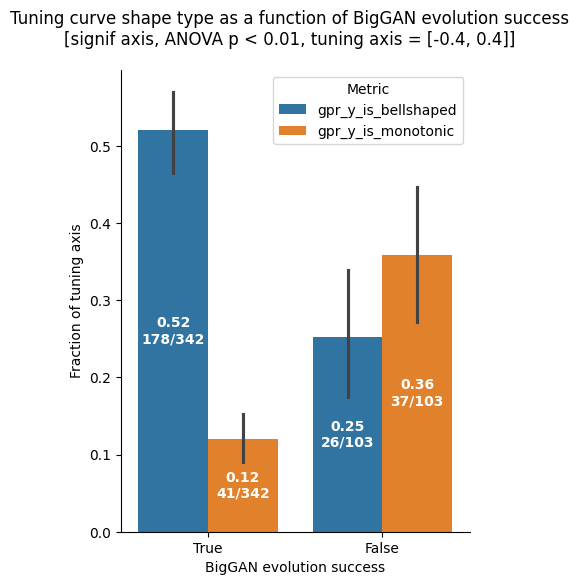

In [36]:
tuning_fitting_stats_table_sel = pd.read_csv(join(source_data_dir, "Figure6E_src_tuning_shape_fitting_stats_synopsis_selcolumn.csv"))
# Modified code to plot multiple bars side by side
# Filter the data based on the given conditions
filtered_data = tuning_fitting_stats_table_sel.query("anova_p_value < 0.01 and is_common_axis")
# Reshape the data to long format for better plotting
melted_data = filtered_data.melt(
    id_vars='is_BigGAN_evol_success',
    value_vars=['gpr_y_is_bellshaped', 'gpr_y_is_monotonic', 'gpr_y_is_unimodal'],
    var_name='Metric',
    value_name='Value'
)

# Compute counts for annotations and sort to match the barplot order
annotation_data = melted_data.groupby(['is_BigGAN_evol_success', 'Metric']).agg(
    True_Count=('Value', 'sum'),
    Total_Count=('Value', 'count'),
    Ratio=('Value', 'mean'),
).reset_index().sort_values(['is_BigGAN_evol_success', 'Metric'])

plt.figure(figsize=(4.5, 6))
# Create a bar plot with multiple bars side by side
ax = sns.barplot(
    data=melted_data,
    x='is_BigGAN_evol_success',
    y='Value',
    hue='Metric',
    order=["True", "False"],
    hue_order=["gpr_y_is_bellshaped", "gpr_y_is_monotonic", ],
    errorbar=("ci", 95),
)

plt.ylabel("Fraction of tuning axis")
plt.xlabel("BigGAN evolution success")

# Add annotations of num of True / total on top of each bar
for p in ax.patches:
    height = p.get_height()
    # get row from annotation_data with same Ratio 
    row = annotation_data[annotation_data['Ratio'] == height]
    if row.empty: # last 
        continue
    row = row.iloc[0]
    ax.annotate(
        f"{row['Ratio']:.2f}\n{int(row['True_Count'])}/{int(row['Total_Count'])}",
        (p.get_x() + p.get_width() / 2., p.get_height() / 2),
        ha='center', va='center', color="white", fontweight="bold", 
    )
    
plt.suptitle("Tuning curve shape type as a function of BigGAN evolution success\n[signif axis, ANOVA p < 0.01, tuning axis = [-0.4, 0.4]]")
# saveallforms(syndir, "BigGAN_evol_success_tuning_shape_type_barplot_simple")
# Display the plot
plt.show()

### Peak dist.

In [130]:
# tuning_stats_synopsis_df = pd.read_pickle(join(syndir, f"ABCD_tuning_stats_synopsis.pkl"))
tuning_stats_synopsis_df_fillmissing = pd.read_pickle(join(syndir, f"ABCD_tuning_stats_synopsis_fill_missing.pkl"))
evol_stats_synopsis_df = pd.read_pickle(join(syndir, f"ABCD_evol_stats_synopsis.pkl"))

tuning_stats_synopsis_df = tuning_stats_synopsis_df_fillmissing
tuning_stats_synopsis_df['eig_id'] = tuning_stats_synopsis_df['eig_id'].astype(int)
tuning_stats_synopsis_df['Exp_id'] = tuning_stats_synopsis_df.apply(lambda row: f"{row['Animal']}_{int(row['Expi'])}", axis=1)

In [133]:
# tuning_stats_synopsis_df['eig_id'] = tuning_stats_synopsis_df['eig_id'].astype(int)
tuning_stats_synopsis_df['max_resp_lin_dist_bin'] = tuning_stats_synopsis_df['max_resp_lin_dist']
# use this to merge the bins at 0.08 and -0.08 to 0.0 ( this rarely happens  )
# [-0.4, -0.32, -0.24, -0.16, 0.0, 0.16, 0.24, 0.32, 0.4] 
tuning_stats_synopsis_df['max_resp_lin_dist_bin'] = tuning_stats_synopsis_df['max_resp_lin_dist_bin'].apply(lambda x: 0.0 if x <=0.08 and x >= -0.08 else x)

In [131]:
common_axis_mask = tuning_stats_synopsis_df.lin_dist_set.map(lambda x: max(x) == 0.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


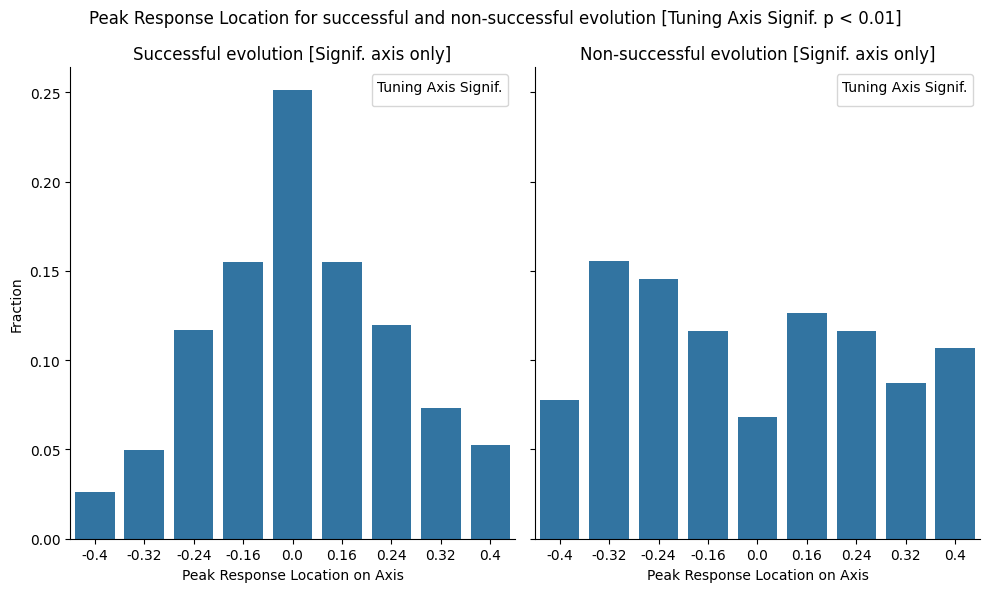

In [135]:
# add a column for statistical significance
for pval_threshold in [0.01]:#[0.005, 0.01, 0.05]:
    tuning_stats_synopsis_df['sig'] = tuning_stats_synopsis_df['p_value'] < pval_threshold
    fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
    sns.countplot(data=tuning_stats_synopsis_df[common_axis_mask].query("Exp_id in @BigGAN_success_explist  and  sig"), 
                x='max_resp_lin_dist_bin', stat='proportion', ax=ax[0], )#bins=[-0.4, -0.32, -0.24, -0.16, 0.0, 0.16, 0.24, 0.32, 0.4])
    ax[0].set_title('Successful evolution [Signif. axis only]')
    ax[0].set_xlabel('Peak Response Location on Axis')
    ax[0].set_ylabel('Fraction')
    ax[0].legend(title='Tuning Axis Signif.')

    sns.countplot(data=tuning_stats_synopsis_df[common_axis_mask].query("Exp_id not in @BigGAN_success_explist  and  sig"), 
                x='max_resp_lin_dist_bin', stat='proportion', ax=ax[1], )#bins=[-0.4, -0.32, -0.24, -0.16, 0.0, 0.16, 0.24, 0.32, 0.4])
    ax[1].set_title('Non-successful evolution [Signif. axis only]')
    ax[1].set_xlabel('Peak Response Location on Axis')
    ax[1].set_ylabel('Fraction')
    ax[1].legend(title='Tuning Axis Signif.')

    fig.suptitle(f'Peak Response Location for successful and non-successful evolution [Tuning Axis Signif. p < {pval_threshold}]')
    plt.tight_layout()
    # saveallforms(synfigdir, f"BigGAN_success_vs_fail_max_resp_lin_dist_countplot_signif_only_merge_p{pval_threshold}", figh=fig)
    plt.show()

In [149]:
curve_count = tuning_stats_synopsis_df[common_axis_mask].query("Exp_id in @BigGAN_success_explist").count()

/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key

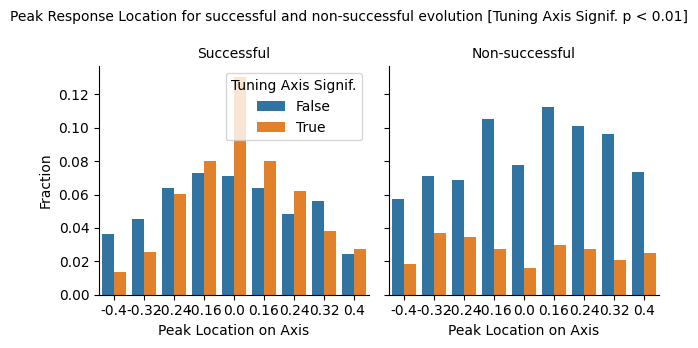

In [ ]:
fs=10
# add a column for statistical significance
for pval_threshold in [0.01]:#[0.005, 0.01, 0.05]:
    tuning_stats_synopsis_df['sig'] = tuning_stats_synopsis_df['p_value'] < pval_threshold
    fig, ax = plt.subplots(1, 2, figsize=(6.5, 3.5), sharey=True)
    sns.countplot(data=tuning_stats_synopsis_df[common_axis_mask].query("Exp_id in @BigGAN_success_explist"), 
                x='max_resp_lin_dist_bin', stat='proportion', ax=ax[0], hue='sig')#bins=[-0.4, -0.32, -0.24, -0.16, 0.0, 0.16, 0.24, 0.32, 0.4])
    curve_count = tuning_stats_synopsis_df[common_axis_mask].query("Exp_id in @BigGAN_success_explist").count()
    ax[0].set_title('Successful', fontsize=fs)
    ax[0].set_xlabel('Peak Location on Axis', fontsize=fs)
    ax[0].set_ylabel('Fraction', fontsize=fs)
    ax[0].legend(title='Tuning Axis Signif.', fontsize=fs)

    sns.countplot(data=tuning_stats_synopsis_df[common_axis_mask].query("Exp_id not in @BigGAN_success_explist"), 
                x='max_resp_lin_dist_bin', stat='proportion', ax=ax[1], hue='sig')#bins=[-0.4, -0.32, -0.24, -0.16, 0.0, 0.16, 0.24, 0.32, 0.4])
    ax[1].set_title('Non-successful', fontsize=fs)
    ax[1].set_xlabel('Peak Location on Axis', fontsize=fs)
    # ax[1].set_ylabel('Fraction')
    # ax[1].legend(title='Tuning Axis Signif.')
    ax[1].get_legend().remove()

    for axi in ax:
        axi.tick_params(axis='x', labelsize=fs)
    fig.suptitle(f'Peak Response Location for successful and non-successful evolution [Tuning Axis Signif. p < {pval_threshold}]', fontsize=fs)
    plt.tight_layout()
    # saveallforms(synfigdir, f"BigGAN_success_vs_fail_max_resp_lin_dist_countplot_signif_only_merge_p{pval_threshold}", figh=fig)
    plt.show()

/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


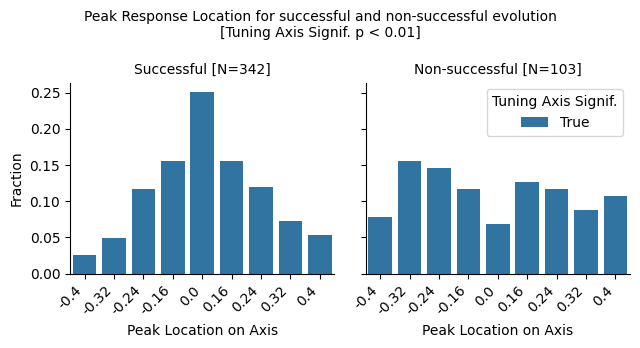

In [157]:
fs=10
# add a column for statistical significance
for pval_threshold in [0.01]:#[0.005, 0.01, 0.05]:
    tuning_stats_synopsis_df['sig'] = tuning_stats_synopsis_df['p_value'] < pval_threshold
    fig, ax = plt.subplots(1, 2, figsize=(6.5, 3.5), sharey=True)
    sns.countplot(data=tuning_stats_synopsis_df[common_axis_mask].query("Exp_id in @BigGAN_success_explist and sig"), 
                x='max_resp_lin_dist_bin', stat='proportion', ax=ax[0], hue='sig')#bins=[-0.4, -0.32, -0.24, -0.16, 0.0, 0.16, 0.24, 0.32, 0.4])
    curve_count = len(tuning_stats_synopsis_df[common_axis_mask].query("Exp_id in @BigGAN_success_explist and sig"))
    ax[0].set_title(f'Successful [N={curve_count}]', fontsize=fs)
    ax[0].set_xlabel('Peak Location on Axis', fontsize=fs)
    ax[0].set_ylabel('Fraction', fontsize=fs)
    ax[0].legend(title='Tuning Axis Signif.', fontsize=fs)
    ax[0].get_legend().remove()

    sns.countplot(data=tuning_stats_synopsis_df[common_axis_mask].query("Exp_id not in @BigGAN_success_explist and sig"), 
                x='max_resp_lin_dist_bin', stat='proportion', ax=ax[1], hue='sig')#bins=[-0.4, -0.32, -0.24, -0.16, 0.0, 0.16, 0.24, 0.32, 0.4])
    curve_count = len(tuning_stats_synopsis_df[common_axis_mask].query("Exp_id not in @BigGAN_success_explist and sig"))
    ax[1].set_title(f'Non-successful [N={curve_count}]', fontsize=fs)
    ax[1].set_xlabel('Peak Location on Axis', fontsize=fs)
    # ax[1].set_ylabel('Fraction')
    ax[1].legend(title='Tuning Axis Signif.', fontsize=fs)
    # ax[1].get_legend().remove()

    for axi in ax:
        for label in axi.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')
        axi.tick_params(axis='x', labelsize=fs)
    fig.suptitle(f'Peak Response Location for successful and non-successful evolution\n[Tuning Axis Signif. p < {pval_threshold}]', fontsize=fs)
    plt.tight_layout()
    saveallforms(source_data_dir, f"BigGAN_success_vs_fail_max_resp_lin_dist_countplot_signif_only_merge_p{pval_threshold}_export", figh=fig)
    # saveallforms(synfigdir, f"BigGAN_success_vs_fail_max_resp_lin_dist_countplot_signif_only_merge_p{pval_threshold}", figh=fig)
    plt.show()

In [160]:
bar_positions

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 0.0]

In [161]:
props.values

array([0.02631579, 0.0497076 , 0.11695906, 0.15497076, 0.25146199,
       0.15497076, 0.11988304, 0.07309942, 0.05263158])

In [165]:
counts

max_resp_lin_dist_bin
-0.40     9
-0.32    17
-0.24    40
-0.16    53
 0.00    86
 0.16    53
 0.24    41
 0.32    25
 0.40    18
Name: count, dtype: int64

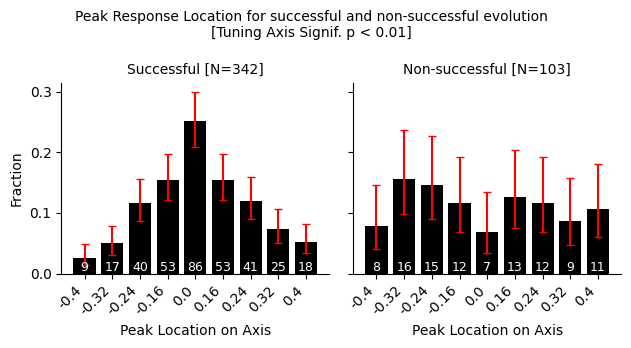

In [174]:
import numpy as np
from statsmodels.stats.proportion import proportion_confint

fs = 10
for pval_threshold in [0.01]:
    tuning_stats_synopsis_df['sig'] = tuning_stats_synopsis_df['p_value'] < pval_threshold
    fig, ax = plt.subplots(1, 2, figsize=(6.5, 3.5), sharey=True)

    # --- LEFT: Successful ---
    df_succ = tuning_stats_synopsis_df[common_axis_mask].query(
        "Exp_id in @BigGAN_success_explist and sig"
    )

    sns.countplot(
        data=df_succ,
        x='max_resp_lin_dist_bin',
        stat='proportion',
        ax=ax[0],
        color='k',
        # hue='sig'
    )
    curve_count = len(df_succ)
    ax[0].set_title(f'Successful [N={curve_count}]', fontsize=fs)
    ax[0].set_xlabel('Peak Location on Axis', fontsize=fs)
    ax[0].set_ylabel('Fraction', fontsize=fs)
    # ax[0].get_legend().remove()

    # compute binomial CIs on the proportions in this panel
    counts = df_succ['max_resp_lin_dist_bin'].value_counts().sort_index()
    N = counts.sum()
    props = counts / N

    # Wilson 95% CI
    ci_low, ci_high = proportion_confint(counts.values, N, alpha=0.05, method='wilson')
    err_low = props.values - ci_low
    err_high = ci_high - props.values

    # x positions of bars in this axis
    bar_positions = [patch.get_x() + patch.get_width() / 2
                     for patch in ax[0].patches]

    ax[0].errorbar(
        bar_positions,
        np.repeat(props.values, 1),          # one bar per category
        yerr=[err_low, err_high],
        fmt='none',
        capsize=3,
        linewidth=1.5,
        color='red',
    )

    # Mark the count number at the base of each bar
    for xpos, count in zip(bar_positions, counts.values):
        ax[0].text(xpos, 0, str(count),
                   ha='center', va='bottom', fontsize=fs-1, color='white', rotation=0) # fontweight='bold', 

    # --- RIGHT: Non-successful ---
    df_fail = tuning_stats_synopsis_df[common_axis_mask].query(
        "Exp_id not in @BigGAN_success_explist and sig"
    )

    sns.countplot(
        data=df_fail,
        x='max_resp_lin_dist_bin',
        stat='proportion',
        ax=ax[1],
        color='k',
        # hue='sig'
    )
    curve_count = len(df_fail)
    ax[1].set_title(f'Non-successful [N={curve_count}]', fontsize=fs)
    ax[1].set_xlabel('Peak Location on Axis', fontsize=fs)

    # CI for this panel
    counts2 = df_fail['max_resp_lin_dist_bin'].value_counts().sort_index()
    N2 = counts2.sum()
    props2 = counts2 / N2
    ci_low2, ci_high2 = proportion_confint(counts2.values, N2, alpha=0.05, method='wilson')
    err_low2 = props2.values - ci_low2
    err_high2 = ci_high2 - props2.values
    bar_positions2 = [patch.get_x() + patch.get_width() / 2
                      for patch in ax[1].patches]

    ax[1].errorbar(
        bar_positions2,
        np.repeat(props2.values, 1),
        yerr=[err_low2, err_high2],
        fmt='none',
        capsize=3,
        linewidth=1.5,
        color='red',
    )

    # Mark the count number at the base of each bar for right panel
    for xpos, count in zip(bar_positions2, counts2.values):
        ax[1].text(xpos, 0, str(count),
                   ha='center', va='bottom', fontsize=fs-1, color='white', rotation=0) # fontweight='bold', 

    # --- Cosmetics ---
    for axi in ax:
        for label in axi.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')
        axi.tick_params(axis='x', labelsize=fs)

    fig.suptitle(
        f'Peak Response Location for successful and non-successful evolution\n'
        f'[Tuning Axis Signif. p < {pval_threshold}]',
        fontsize=fs
    )
    plt.tight_layout()
    saveallforms(source_data_dir,
                 f"BigGAN_success_vs_fail_max_resp_lin_dist_countplot_signif_only_merge_p{pval_threshold}_annot_export",
                 figh=fig)
    plt.show()

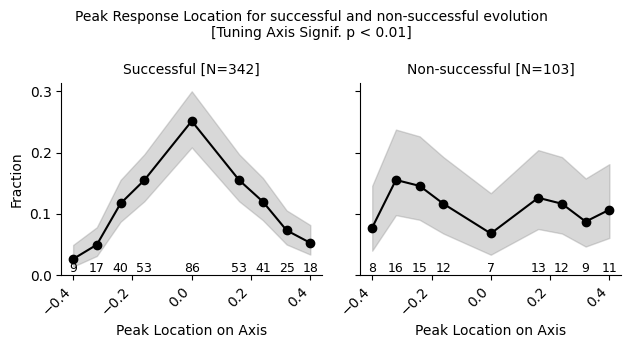

In [176]:
import numpy as np
from statsmodels.stats.proportion import proportion_confint

fs = 10
for pval_threshold in [0.01]:
    tuning_stats_synopsis_df['sig'] = tuning_stats_synopsis_df['p_value'] < pval_threshold
    fig, ax = plt.subplots(1, 2, figsize=(6.5, 3.5), sharey=True)

    # --- LEFT: Successful ---
    df_succ = tuning_stats_synopsis_df[common_axis_mask].query(
        "Exp_id in @BigGAN_success_explist and sig"
    )
    # Sort bin edges using ALL possible bin values for correct ordering
    bin_edges = np.sort(df_succ['max_resp_lin_dist_bin'].unique())
    counts = df_succ['max_resp_lin_dist_bin'].value_counts().sort_index()
    N = counts.sum()
    props = counts / N

    # If some bins are missing (e.g. no count for a value), complete with 0
    all_bins = np.sort(df_succ['max_resp_lin_dist_bin'].unique())
    props_all = np.array([props.get(bin_edge, 0) for bin_edge in all_bins])
    counts_all = np.array([counts.get(bin_edge, 0) for bin_edge in all_bins])

    # CI on all bins (if count=0, lower and upper are 0)
    ci_low, ci_high = proportion_confint(counts_all, N, alpha=0.05, method='wilson')
    err_low = props_all - ci_low
    err_high = ci_high - props_all

    ax[0].plot(all_bins, props_all, marker="o", linestyle='-', color='k', label="Prop.")
    ax[0].fill_between(all_bins, ci_low, ci_high, color='gray', alpha=0.3, label="95% CI")

    # Mark the count number under each point
    for xpos, count in zip(all_bins, counts_all):
        ax[0].text(xpos, 0, str(count),
                   ha='center', va='bottom', fontsize=fs-1, color='black', rotation=0)

    curve_count = len(df_succ)
    ax[0].set_title(f'Successful [N={curve_count}]', fontsize=fs)
    ax[0].set_xlabel('Peak Location on Axis', fontsize=fs)
    ax[0].set_ylabel('Fraction', fontsize=fs)
    # ax[0].legend()
        
    # --- RIGHT: Non-successful ---
    df_fail = tuning_stats_synopsis_df[common_axis_mask].query(
        "Exp_id not in @BigGAN_success_explist and sig"
    )
    counts2 = df_fail['max_resp_lin_dist_bin'].value_counts().sort_index()
    N2 = counts2.sum()
    props2 = counts2 / N2

    props2_all = np.array([props2.get(bin_edge, 0) for bin_edge in all_bins])
    counts2_all = np.array([counts2.get(bin_edge, 0) for bin_edge in all_bins])

    ci_low2, ci_high2 = proportion_confint(counts2_all, N2, alpha=0.05, method='wilson')
    err_low2 = props2_all - ci_low2
    err_high2 = ci_high2 - props2_all

    ax[1].plot(all_bins, props2_all, marker="o", linestyle='-', color='k', label="Prop.")
    ax[1].fill_between(all_bins, ci_low2, ci_high2, color='gray', alpha=0.3, label="95% CI")

    # Mark the count number under each point
    for xpos, count in zip(all_bins, counts2_all):
        ax[1].text(xpos, 0, str(count),
                   ha='center', va='bottom', fontsize=fs-1, color='black', rotation=0)

    curve_count = len(df_fail)
    ax[1].set_title(f'Non-successful [N={curve_count}]', fontsize=fs)
    ax[1].set_xlabel('Peak Location on Axis', fontsize=fs)
    # ax[1].legend()
    
    # --- Cosmetics ---
    for axi in ax:
        axi.set_ylim(bottom=0)
        for label in axi.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')
        axi.tick_params(axis='x', labelsize=fs)

    fig.suptitle(
        f'Peak Response Location for successful and non-successful evolution\n'
        f'[Tuning Axis Signif. p < {pval_threshold}]',
        fontsize=fs
    )
    plt.tight_layout()
    saveallforms(source_data_dir,
                 f"BigGAN_success_vs_fail_max_resp_lin_dist_LINEplot_signif_only_merge_p{pval_threshold}_annot_export",
                 figh=fig)
    plt.show()